# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Aesthetics

In [2]:
scaler = 2
fig_wide = 6.267717 * scaler # width of a4 minus 2.54cm margins either side then x by scaler to scale everything"s size easily
fig_gold = 1.618

# Data Import

In [3]:
# Convert timestamps to datetimes
def convert_time(dataframe, column, format = None, unit = None, new_name = "Time (Datetime)"):
    dataframe[column] = pd.to_datetime(dataframe[column], format = format, unit = unit)
    dataframe.rename(columns = {column: new_name}, inplace = True)

# Clean data
def cleaner(dataframe, variable_name):
    dataframe[variable_name] = dataframe[variable_name].replace([-9999.0], np.nan) # Replace visible/known missing values
    dataframe = dataframe.reindex(pd.date_range(start = dataframe.index[0], end = dataframe.index[-1], freq = "30min")) # Reindex to deal with hidden missing values
    #dataframe.index.name = "date" # put the name of the index column back!
    dataframe = dataframe[[variable_name]].copy() # Select Variables
    return dataframe

Flux Tower Eddy Covariance

In [4]:
# Import flux data
flux = {
    
    # Abisko-Stordalen Palsa Bog flux data
    "Se_Sto": pd.read_csv(
        "../data/flux/abisko-stordalen-palsa-bog/ICOSETC_SE-Sto_FLUXNET_HH_L2.csv", 
        usecols = [
            "TIMESTAMP_END",
            "GPP_DT_VUT_REF", # gross primary production
            "SWC_F_MDS_1", # soil water content at depth 1, gap-filled with MDS
            "SWC_F_MDS_2", # soil water content at depth 2, gap-filled with MDS
            "SWC_F_MDS_3", # soil water content at depth 3, gap-filled with MDS
            "SWC_F_MDS_4", # soil water content at depth 4, gap-filled with MDS
            "SWC_F_MDS_5", # soil water content at depth 5, gap-filled with MDS
            "SWC_F_MDS_6" # soil water content at depth 6, gap-filled with MDS
        ]
    ),

    # Kenttarova flux data
    "Fi_Ken": pd.read_csv(
        "../data/flux/kenttarova/ICOSETC_FI-Ken_FLUXNET_HH_L2.csv",
        usecols = [
            "TIMESTAMP_END",
            "GPP_DT_VUT_REF", # gross primary production
            "SWC_F_MDS_1", # soil water content at depth 1, gap-filled with MDS
            "SWC_F_MDS_2" # soil water content at depth 2, gap-filled with MDS
        ]
    ),

    # Sodankyla flux data
    "Fi_Sod": pd.read_csv(
        "../data/flux/sodankyla/ICOSETC_FI-Sod_FLUXNET_HH_L2.csv",
        usecols = [
            "TIMESTAMP_END",
            "GPP_DT_VUT_REF", # gross primary production
            "SWC_F_MDS_1", # soil water content at depth 1, gap-filled with MDS
            "SWC_F_MDS_2", # soil water content at depth 2, gap-filled with MDS
            "SWC_F_MDS_3", # soil water content at depth 3, gap-filled with MDS
            "SWC_F_MDS_4", # soil water content at depth 4, gap-filled with MDS
            "SWC_F_MDS_5" # soil water content at depth 5, gap-filled with MDS
        ]
    ),

    # Varrio flux data
    "Fi_Var": pd.read_csv(
        "../data/flux/varrio/ICOSETC_FI-Var_FLUXNET_HH_L2.csv",
        usecols = [
            "TIMESTAMP_END",
            "GPP_DT_VUT_REF", # gross primary production
            "SWC_F_MDS_1", # soil water content at depth 1, gap-filled with MDS
            "SWC_F_MDS_2", # soil water content at depth 2, gap-filled with MDS
        ]
    )

}

# Rename Columns
flux["Se_Sto"].rename(columns = {
    "TIMESTAMP_END": "Time (Unix)",
    "GPP_DT_VUT_REF": "Gross Primary Production (µmol)",
    "SWC_F_MDS_1": "Soil Water Content Depth 1 (%)",
    "SWC_F_MDS_2": "Soil Water Content Depth 2 (%)",
    "SWC_F_MDS_3": "Soil Water Content Depth 3 (%)",
    "SWC_F_MDS_4": "Soil Water Content Depth 4 (%)",
    "SWC_F_MDS_5": "Soil Water Content Depth 5 (%)",
    "SWC_F_MDS_6": "Soil Water Content Depth 6 (%)"
    }, inplace=True)
flux["Fi_Ken"].rename(columns = {
    "TIMESTAMP_END": "Time (Unix)",
    "GPP_DT_VUT_REF": "Gross Primary Production (µmol)",
    "SWC_F_MDS_1": "Soil Water Content Depth 1 (%)",
    "SWC_F_MDS_2": "Soil Water Content Depth 2 (%)"
    }, inplace=True)
flux["Fi_Sod"].rename(columns = {
    "TIMESTAMP_END": "Time (Unix)",
    "GPP_DT_VUT_REF": "Gross Primary Production (µmol)",
    "SWC_F_MDS_1": "Soil Water Content Depth 1 (%)",
    "SWC_F_MDS_2": "Soil Water Content Depth 2 (%)",
    "SWC_F_MDS_3": "Soil Water Content Depth 3 (%)",
    "SWC_F_MDS_4": "Soil Water Content Depth 4 (%)",
    "SWC_F_MDS_5": "Soil Water Content Depth 5 (%)"
    }, inplace=True)
flux["Fi_Var"].rename(columns = {
    "TIMESTAMP_END": "Time (Unix)",
    "GPP_DT_VUT_REF": "Gross Primary Production (µmol)",
    "SWC_F_MDS_1": "Soil Water Content Depth 1 (%)",
    "SWC_F_MDS_2": "Soil Water Content Depth 2 (%)"
    }, inplace=True)

# Run Pre-processing
for location, dataframe in flux.items():
    convert_time(dataframe, "Time (Unix)", "%Y%m%d%H%M") # Convert unix timestamps to datetimes
    dataframe = dataframe.set_index("Time (Datetime)", drop = False) # Make the new datetime column the index
    dataframe.sort_index(inplace = True) # Sort by time
    dataframe = pd.concat([cleaner(dataframe[[column]].copy(), column) for column in dataframe.columns], axis = 1) # Clean and reassign dataFrame
    dataframe["Time (Time of Day)"] = [datetime.datetime.combine(datetime.date.today(), t) for t in dataframe["Time (Datetime)"].dt.time] # Add Time of Day. https://stackoverflow.com/questions/32832431/how-to-use-datetime-time-to-plot
    dataframe["Time (Day of Year)"] = dataframe["Time (Datetime)"].dt.dayofyear # Add Day of Year. Returns 1 for January 1st
    dataframe["Time (Unix)"] = dataframe["Time (Time of Day)"].astype(int) / 10**9 # Remake unix time from datetime (we"re remaking it so the flux and satellite unix times are the same length)
    flux[location] = dataframe
    
# Preview
flux["Se_Sto"]

,Time (Datetime),Soil Water Content Depth 1 (%),Soil Water Content Depth 2 (%),Soil Water Content Depth 3 (%),Soil Water Content Depth 4 (%),Soil Water Content Depth 5 (%),Soil Water Content Depth 6 (%),Gross Primary Production (µmol),Time (Time of Day),Time (Day of Year),Time (Unix)
2022-01-01 00:30:00,2022-01-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2025-05-06 00:30:00,1,1.746491e+09
2022-01-01 01:00:00,2022-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2025-05-06 01:00:00,1,1.746493e+09
2022-01-01 01:30:00,2022-01-01 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2025-05-06 01:30:00,1,1.746495e+09
2022-01-01 02:00:00,2022-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2025-05-06 02:00:00,1,1.746497e+09
2022-01-01 02:30:00,2022-01-01 02:30:00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2025-05-06 02:30:00,1,1.746499e+09
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 22:00:00,2024-12-31 22:00:00,1.61,1.22,0.0,8.18,29.15,26.04,0.0,2025-05-06 22:00:00,366,1.746569e+09
2024-12-31 22:30:00,2024-12-31 22:30:00,1.47,1.12,0.0,8.14,29.07,26.05,0.0,2025-05-06 22:30:00,366,1.746571e+09
2024-12-31 23:00:00,2024-12-31 23:00:00,1.63,1.19,0.0,8.19,29.11,26.12,0.0,2025-05-06 23:00:00,366,1.746572e+09
2024-12-31 23:30:00,2024-12-31 23:30:00,1.60,1.21,0.0,8.30,29.10,26.12,0.0,2025-05-06 23:30:00,366,1.746574e+09


Preview Primary Production Data

Text(0.02, 0.5, 'Daytime Gross Primary Production (µmol CO$^2$ m$^-$$^2$ s$^-$$^1$)')

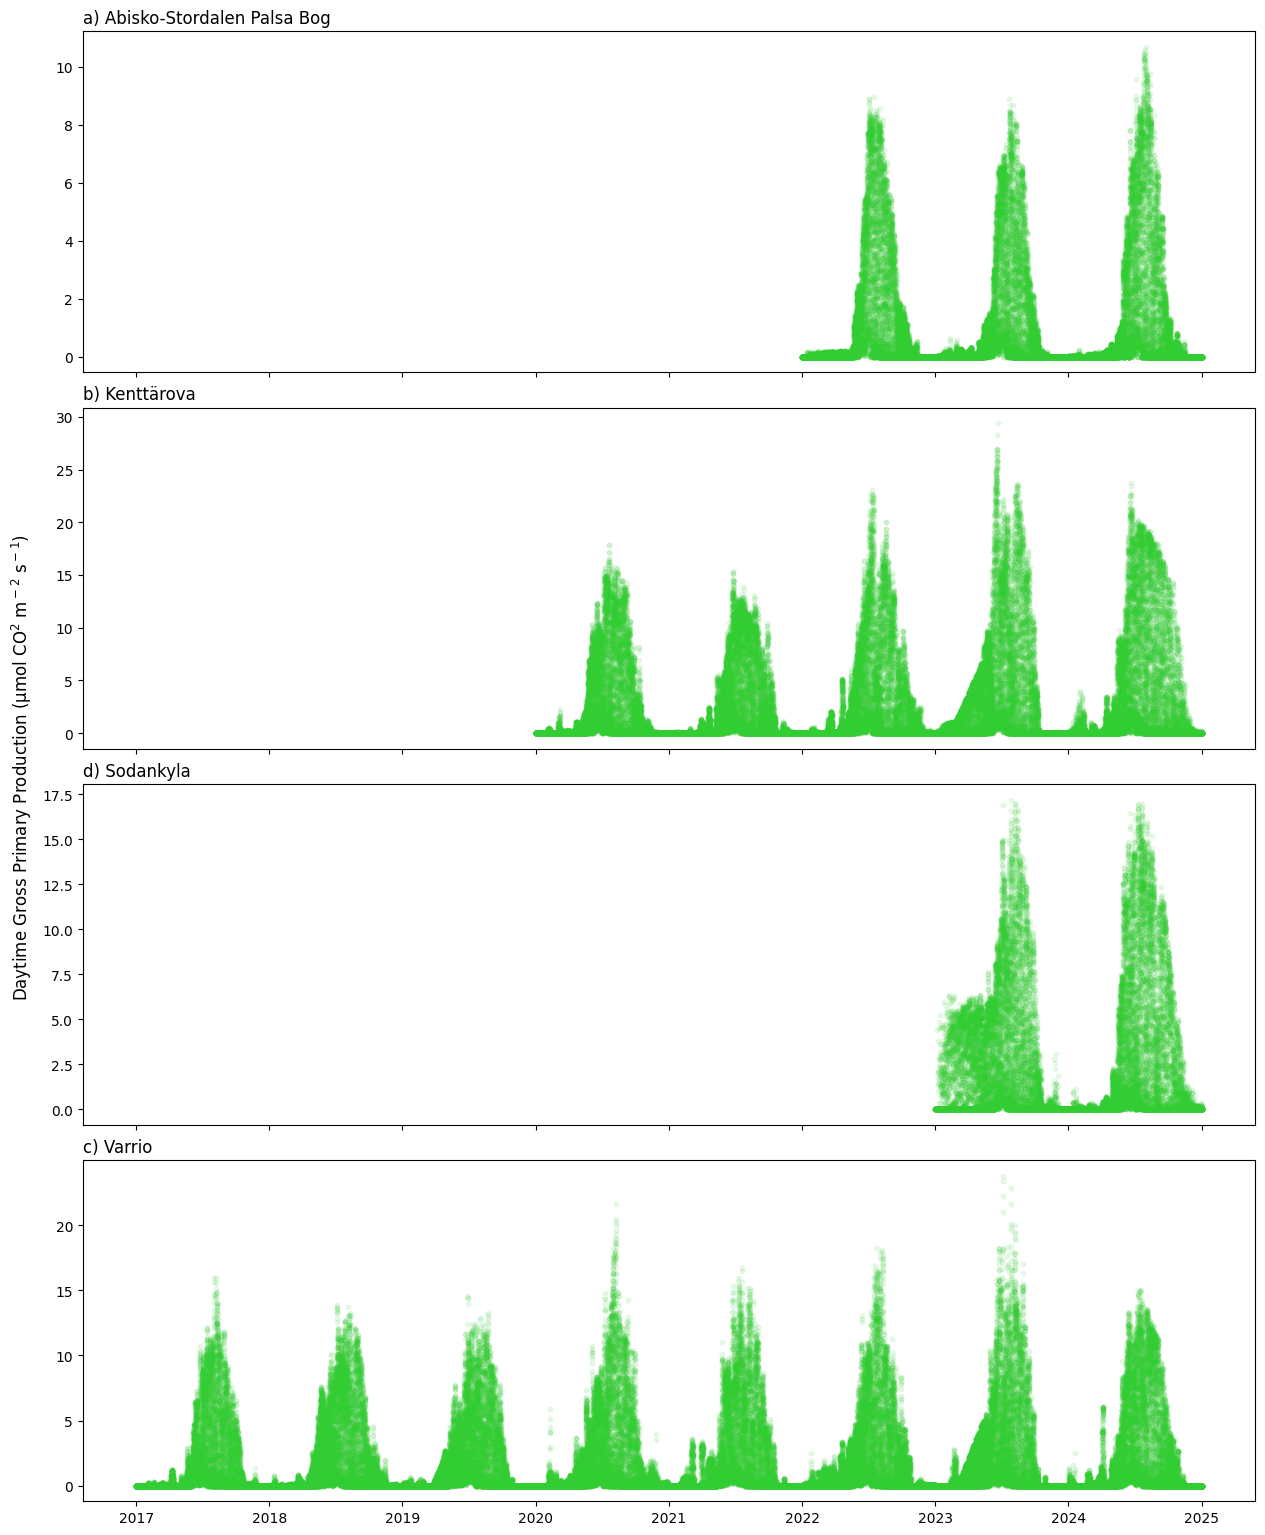

In [5]:
nrows = 4
ncols = 1
squish_factor = 8
fig, ax = plt.subplots(
    nrows = nrows, ncols = ncols, 
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = True, constrained_layout = True
)
ax = ax.flatten()

ax[0].scatter(
    x = flux["Se_Sto"]["Time (Datetime)"], y = flux["Se_Sto"]["Gross Primary Production (µmol)"],
    c = "limegreen", s = 10, alpha = 0.1, edgecolors = None
)
ax[0].set_title("a) Abisko-Stordalen Palsa Bog", loc = "left")

ax[1].scatter(
    x = flux["Fi_Ken"]["Time (Datetime)"], y = flux["Fi_Ken"]["Gross Primary Production (µmol)"],
    c = "limegreen", s = 10, alpha = 0.1, edgecolors = None
)
ax[1].set_title("b) Kenttärova", loc = "left")

ax[2].scatter(
    x = flux["Fi_Sod"]["Time (Datetime)"], y = flux["Fi_Sod"]["Gross Primary Production (µmol)"],
    c = "limegreen", s = 10, alpha = 0.1, edgecolors = None
)
ax[2].set_title("d) Sodankyla", loc = "left")

ax[3].scatter(
    x = flux["Fi_Var"]["Time (Datetime)"], y = flux["Fi_Var"]["Gross Primary Production (µmol)"],
    c = "limegreen", s = 10, alpha = 0.1, edgecolors = None
)
ax[3].set_title("c) Varrio", loc = "left")

fig.supylabel("Daytime Gross Primary Production (µmol CO$^2$ m$^-$$^2$ s$^-$$^1$)")

Text(0.0, 1.0, 'a) Abisko-Stordalen Palsa Bog - Summer Time of Day')

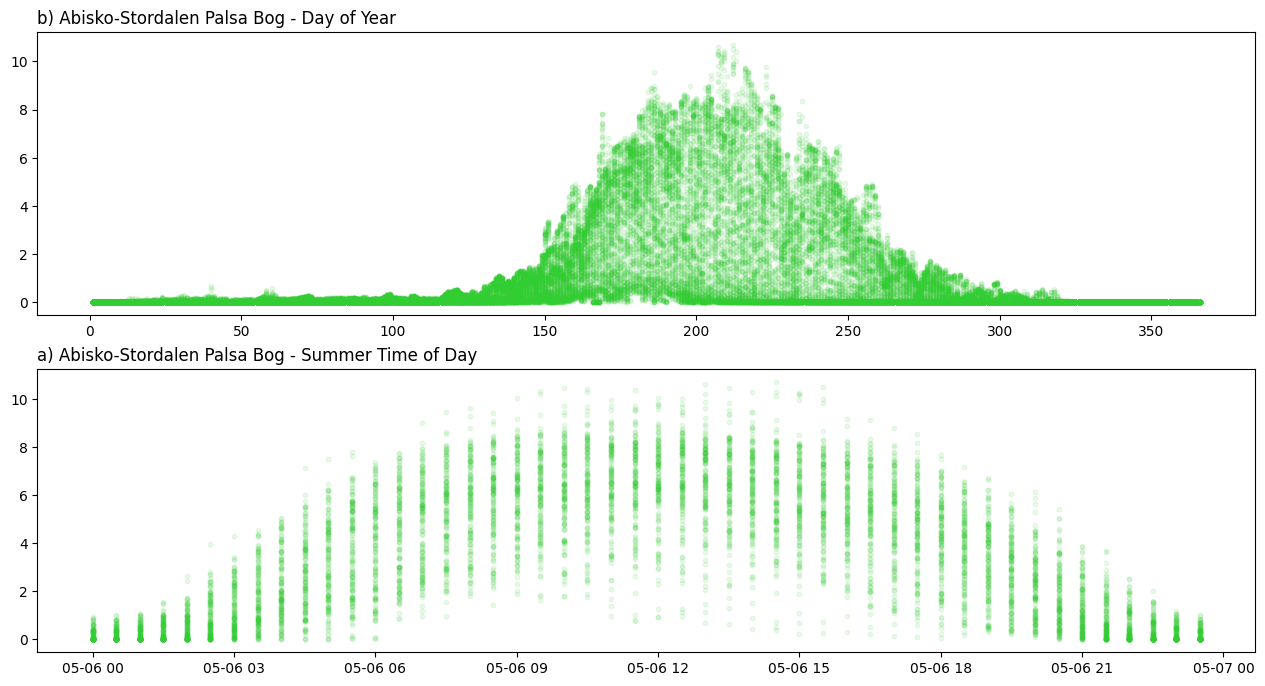

In [6]:
filtered = flux["Se_Sto"][(flux["Se_Sto"]["Time (Day of Year)"] > 175) & (flux["Se_Sto"]["Time (Day of Year)"] < 225)]

nrows = 2
ncols = 1
squish_factor = 1
fig, ax = plt.subplots(
    nrows = nrows, ncols = ncols, 
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout = True
)
ax = ax.flatten()

ax[0].scatter(
    x = flux["Se_Sto"]["Time (Day of Year)"], y = flux["Se_Sto"]["Gross Primary Production (µmol)"],
    c = "limegreen", s = 10, alpha = 0.1, edgecolors = None
)
ax[0].set_title("b) Abisko-Stordalen Palsa Bog - Day of Year", loc = "left")

ax[1].scatter(
    x = filtered["Time (Time of Day)"], y = filtered["Gross Primary Production (µmol)"],
    c = "limegreen", s = 10, alpha = 0.1, edgecolors = None
)
ax[1].set_title("a) Abisko-Stordalen Palsa Bog - Summer Time of Day", loc = "left")

Text(0.02, 0.5, 'Soil Water Content Depth 1 (%)')

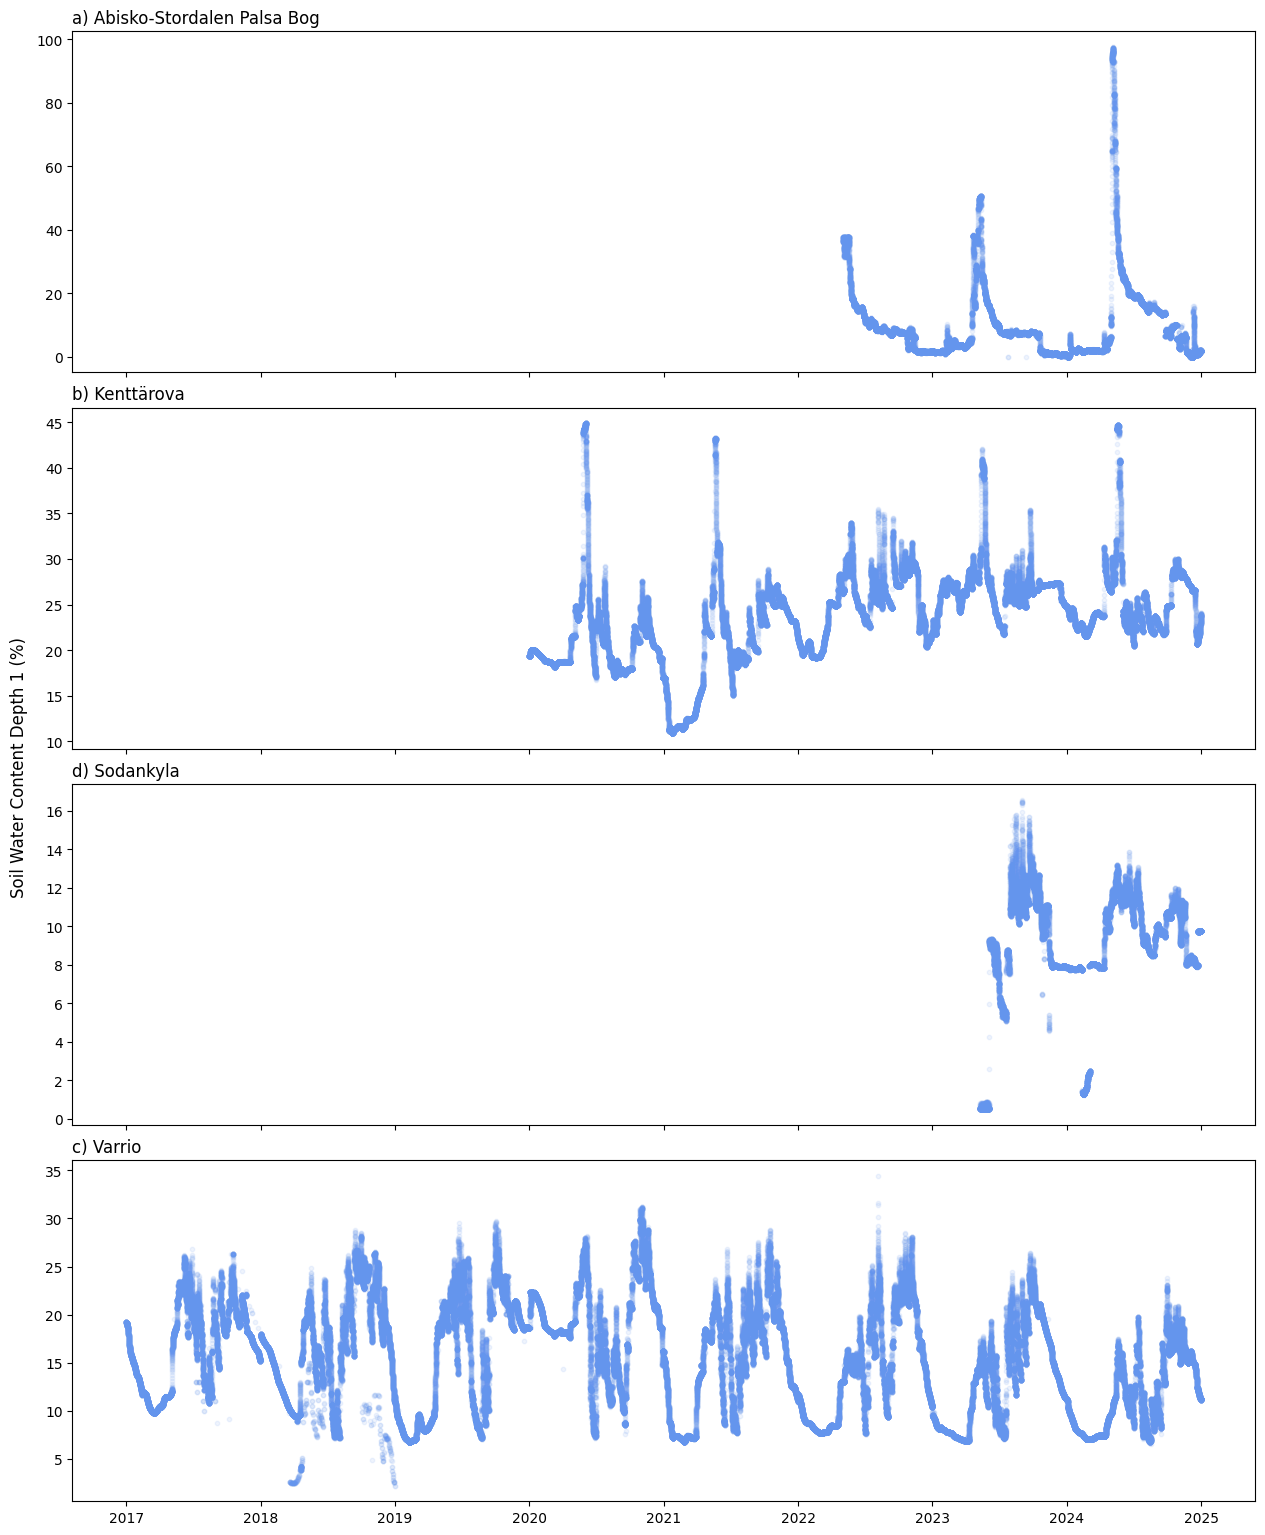

In [6]:
nrows = 4
ncols = 1
squish_factor = 8
fig, ax = plt.subplots(
    nrows = nrows, ncols = ncols, 
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = True, constrained_layout = True
)
ax = ax.flatten()

ax[0].scatter(
    x = flux["Se_Sto"]["Time (Datetime)"], y = flux["Se_Sto"]["Soil Water Content Depth 1 (%)"],
    c = "cornflowerblue", s = 10, alpha = 0.1, edgecolors = None
)
ax[0].set_title("a) Abisko-Stordalen Palsa Bog", loc = "left")

ax[1].scatter(
    x = flux["Fi_Ken"]["Time (Datetime)"], y = flux["Fi_Ken"]["Soil Water Content Depth 1 (%)"],
    c = "cornflowerblue", s = 10, alpha = 0.1, edgecolors = None
)
ax[1].set_title("b) Kenttärova", loc = "left")

ax[2].scatter(
    x = flux["Fi_Sod"]["Time (Datetime)"], y = flux["Fi_Sod"]["Soil Water Content Depth 1 (%)"],
    c = "cornflowerblue", s = 10, alpha = 0.1, edgecolors = None
)
ax[2].set_title("d) Sodankyla", loc = "left")

ax[3].scatter(
    x = flux["Fi_Var"]["Time (Datetime)"], y = flux["Fi_Var"]["Soil Water Content Depth 1 (%)"],
    c = "cornflowerblue", s = 10, alpha = 0.1, edgecolors = None
)
ax[3].set_title("c) Varrio", loc = "left")

fig.supylabel("Soil Water Content Depth 1 (%)")

Satellite Data

In [7]:
satellite = {

    "Se_Sto": pd.read_csv("../data/satellite/tundra-flux_data.csv")

}

# Rename Columns
satellite["Se_Sto"].rename(columns = {
    "time": "Time (Unix)",
    "solarElevation": "Solar Elevation (Degrees)",
    "platformID": "Platform ID",
    "Red": "Red (Rad)",
    "NIR": "NIR (Rad)",
    "SWIR_1": "SWIR (Rad)",
    }, inplace = True)

# Run Pre-processing
for location, dataframe in satellite.items():
    convert_time(dataframe, "Time (Unix)", unit = "ms") # Convert unix timestamps to datetimes
    
    # TEMPORARY - Shift MODIS Time Data to midday
    mask = dataframe["Platform ID"].isin(["MOD09A1", "MYD09A1", "VNP09GA"])
    dataframe.loc[mask, "Time (Datetime)"] = dataframe.loc[mask, "Time (Datetime)"].dt.normalize() + pd.Timedelta(hours = 10.5)
    
    dataframe = dataframe.set_index("Time (Datetime)", drop = False) # Make the new datetime column the index
    dataframe["Time (Time of Day)"] = [datetime.datetime.combine(datetime.date.today(), t) for t in dataframe["Time (Datetime)"].dt.time] # Add Time of Day. https://stackoverflow.com/questions/32832431/how-to-use-datetime-time-to-plot
    dataframe["Time (Day of Year)"] = dataframe["Time (Datetime)"].dt.dayofyear # Add Day of Year. Returns 1 for January 1st
    dataframe.sort_index(inplace = True)
    # No cleaning needed/possible as we have duplicate time values and I also made this data so I know it is clean.
    dataframe.rename_axis(None, inplace = True) # all we need to do is remove the index column header (otherwise using .merge won"t work)
    dataframe["Time (Unix)"] = dataframe["Time (Time of Day)"].astype(int) / 10**9 # Remake unix time from datetime (we"re remaking it so the flux and satellite unix times are the same length)
    
    # Filter out bad satellites (TEMPORARY)
    dataframe = dataframe[dataframe["Platform ID"] != "AST_L1T_003"]
    dataframe = dataframe[dataframe["Platform ID"] != "MOD09A1"]
    dataframe = dataframe[dataframe["Platform ID"] != "MYD09A1"]
    dataframe = dataframe[dataframe["Platform ID"] != "VNP09GA"]
    
    # Make Vegetation Indices
    dataframe["NDVI"] = (dataframe["NIR (Rad)"] - dataframe["Red (Rad)"]) / (dataframe["NIR (Rad)"] + dataframe["Red (Rad)"]) # NDVI
    dataframe = dataframe[(dataframe["NDVI"] > -1) & (dataframe["NDVI"] < 1)] # Clean by NDVI -1 to +1
    dataframe["NIRv"] = ( (dataframe["NIR (Rad)"] - dataframe["Red (Rad)"]) / (dataframe["NIR (Rad)"] + dataframe["Red (Rad)"]) - 0.08 ) * dataframe["NIR (Rad)"] # NIRv
    
    satellite[location] = dataframe

satellite["Se_Sto"]

,Red (Rad),NIR (Rad),SWIR (Rad),Platform ID,Solar Elevation (Degrees),Time (Datetime),Time (Time of Day),Time (Day of Year),Time (Unix),NDVI,NIRv
1984-05-09 09:56:29.675,0.214737,0.273736,0.192139,LT05,38.537672,1984-05-09 09:56:29.675,2025-05-06 09:56:29.675,130,1.746525e+09,0.120782,0.011163
1984-05-25 09:56:58.138,0.095795,0.184126,0.171109,LT05,42.059375,1984-05-25 09:56:58.138,2025-05-06 09:56:58.138,146,1.746525e+09,0.315557,0.043372
1984-05-27 09:44:39.425,0.097170,0.193886,0.180156,LT05,42.394020,1984-05-27 09:44:39.425,2025-05-06 09:44:39.425,148,1.746525e+09,0.332296,0.048917
1984-06-03 09:50:59.417,0.073457,0.213075,0.192667,LT05,43.361882,1984-06-03 09:50:59.417,2025-05-06 09:50:59.417,155,1.746525e+09,0.487269,0.086779
1984-09-16 09:46:49.616,0.100282,0.240355,0.209501,LT05,23.693273,1984-09-16 09:46:49.616,2025-05-06 09:46:49.616,260,1.746525e+09,0.411211,0.079608
...,...,...,...,...,...,...,...,...,...,...,...
2025-04-13 10:31:52.220,1.165230,1.160402,0.221526,S2_SR_HARMONIZED,31.182762,2025-04-13 10:31:52.220,2025-05-06 10:31:52.220,103,1.746528e+09,-0.002076,-0.095241
2025-04-13 10:31:55.835,1.212644,1.219387,0.200213,S2_SR_HARMONIZED,31.195279,2025-04-13 10:31:55.835,2025-05-06 10:31:55.835,103,1.746528e+09,0.002773,-0.094170
2025-04-13 10:42:00.407,0.648237,0.589877,0.069460,S2_SR_HARMONIZED,31.203559,2025-04-13 10:42:00.407,2025-05-06 10:42:00.407,103,1.746528e+09,-0.047136,-0.074995
2025-04-13 10:42:04.245,0.649941,0.594458,0.070948,S2_SR_HARMONIZED,31.239150,2025-04-13 10:42:04.245,2025-05-06 10:42:04.245,103,1.746528e+09,-0.044586,-0.074061


Preview

Text(0.02, 0.5, 'Vegetation Index')

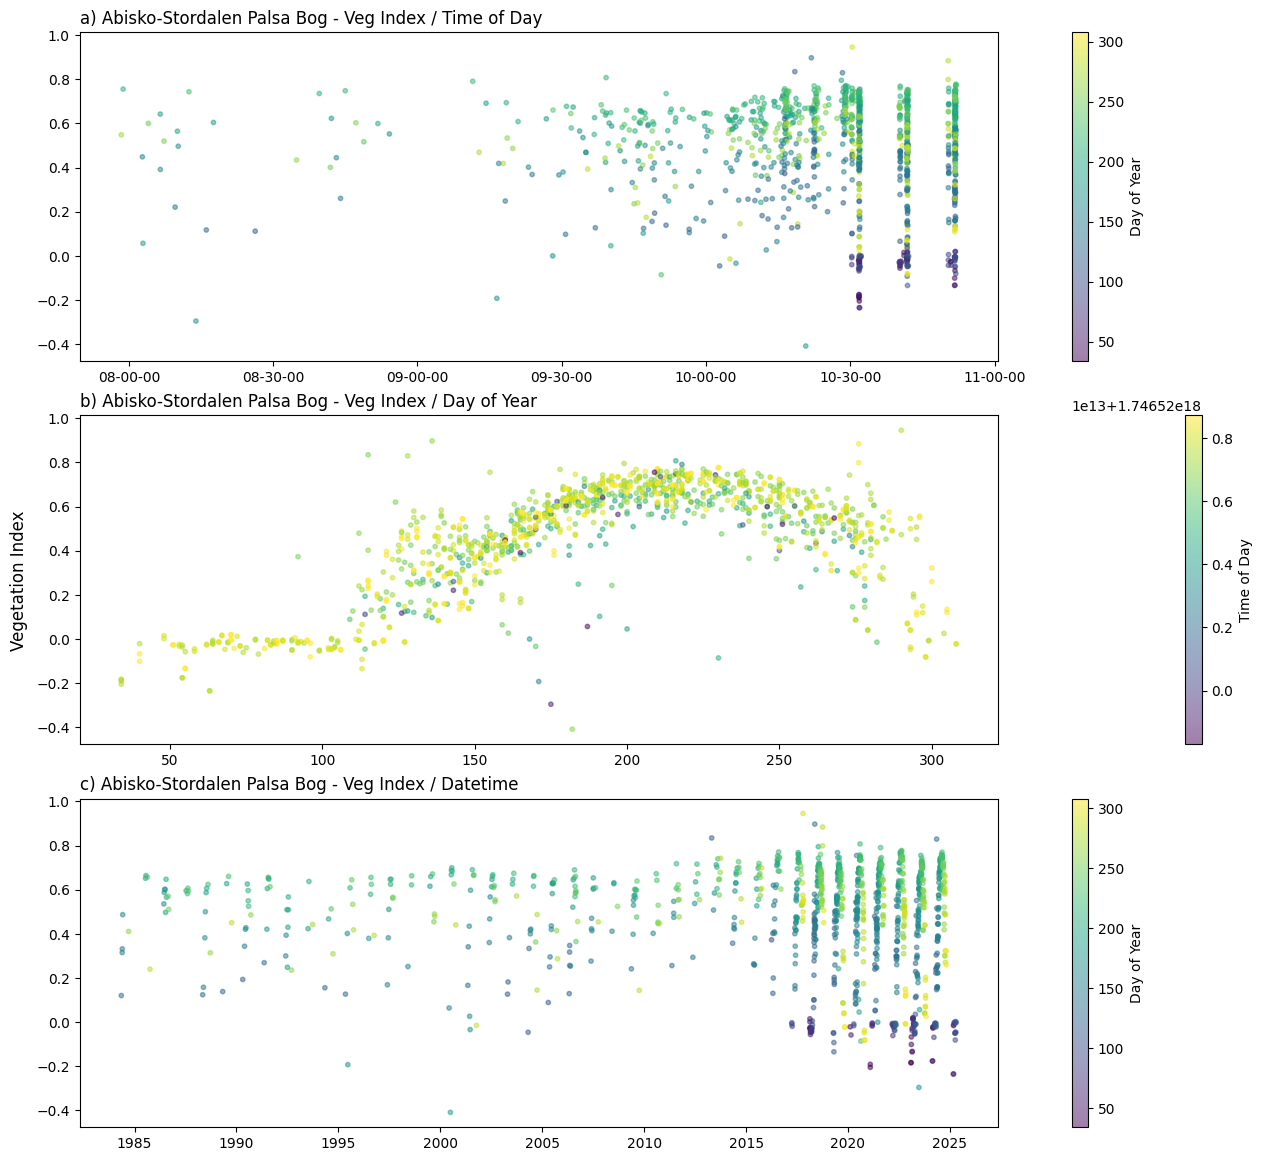

In [8]:
nrows = 3
ncols = 1
squish_factor = 4
fig, ax = plt.subplots(
    nrows = nrows, ncols=ncols,
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout=True
)
ax = ax.flatten()

sp0 = ax[0].scatter(
    x = satellite["Se_Sto"]["Time (Time of Day)"], y = satellite["Se_Sto"]["NDVI"],
    c = satellite["Se_Sto"]["Time (Day of Year)"], s = 10, alpha = 0.5, edgecolors = None,
)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H-%M-%S"))
ax[0].set_title("a) Abisko-Stordalen Palsa Bog - Veg Index / Time of Day", loc = "left")
fig.colorbar(sp0, ax = ax[0], label = "Day of Year")

sp1 = ax[1].scatter(
    x = satellite["Se_Sto"]["Time (Day of Year)"], y = satellite["Se_Sto"]["NDVI"],
    c = satellite["Se_Sto"]["Time (Time of Day)"], s = 10, alpha = 0.5, edgecolors = None,
)
ax[1].set_title("b) Abisko-Stordalen Palsa Bog - Veg Index / Day of Year", loc="left")
fig.colorbar(sp1, ax=ax[1], label="Time of Day")

sp2 = ax[2].scatter(
    x = satellite["Se_Sto"]["Time (Datetime)"], y = satellite["Se_Sto"]["NDVI"],
    c = satellite["Se_Sto"]["Time (Day of Year)"], s = 10, alpha = 0.5, edgecolors = None,
)
ax[2].set_title("c) Abisko-Stordalen Palsa Bog - Veg Index / Datetime", loc="left")
fig.colorbar(sp2, ax=ax[2], label="Day of Year")

fig.supylabel("Vegetation Index")

# Processing

Pair Satellite to Flux Tower Data Points

In [9]:
paired = {}

for location in satellite.keys():
    
    # Clip satellite to flux tower min and max times
    datetime_start = flux[location]["Time (Datetime)"].min()
    datetime_end = flux[location]["Time (Datetime)"].max()
    satellite[location] = satellite[location].dropna(subset = ["Time (Datetime)"])
    satellite_df_clip = satellite[location][(satellite[location]["Time (Datetime)"] >= datetime_start) & (satellite[location]["Time (Datetime)"] <= datetime_end)]
    
    # Merge Satellite and Flux data by nearest datetime column values
    merged = pd.merge_asof(
        satellite_df_clip, flux[location],
        left_on = "Time (Datetime)", right_on = "Time (Datetime)",
        direction = "nearest",
        suffixes = ("", "_flux") # keep satellite cols without suffix so that when we apply the random forest model we dont have to change col names. Append _flux to duplicate flux cols
    )
    
    paired[location] = merged

paired["Se_Sto"]

,Red (Rad),NIR (Rad),SWIR (Rad),Platform ID,Solar Elevation (Degrees),Time (Datetime),Time (Time of Day),Time (Day of Year),Time (Unix),NDVI,...,Soil Water Content Depth 1 (%),Soil Water Content Depth 2 (%),Soil Water Content Depth 3 (%),Soil Water Content Depth 4 (%),Soil Water Content Depth 5 (%),Soil Water Content Depth 6 (%),Gross Primary Production (µmol),Time (Time of Day)_flux,Time (Day of Year)_flux,Time (Unix)_flux
0,0.864453,0.843725,0.129465,S2_SR_HARMONIZED,15.923601,2022-03-05 10:31:53.343,2025-05-06 10:31:53.343,64,1.746528e+09,-0.012134,...,NaN,NaN,NaN,NaN,NaN,NaN,0.088997,2025-05-06 10:30:00,64,1.746527e+09
1,0.874010,0.863960,0.140315,S2_SR_HARMONIZED,15.916325,2022-03-05 10:31:56.964,2025-05-06 10:31:56.964,64,1.746528e+09,-0.005782,...,NaN,NaN,NaN,NaN,NaN,NaN,0.088997,2025-05-06 10:30:00,64,1.746527e+09
2,0.893597,0.791430,0.024437,S2_SR_HARMONIZED,19.859918,2022-03-15 10:31:53.452,2025-05-06 10:31:53.452,74,1.746528e+09,-0.060632,...,NaN,NaN,NaN,NaN,NaN,NaN,0.055258,2025-05-06 10:30:00,74,1.746527e+09
3,0.898537,0.865735,0.106095,S2_SR_HARMONIZED,24.263447,2022-03-26 10:51:41.465,2025-05-06 10:51:41.465,85,1.746529e+09,-0.018593,...,NaN,NaN,NaN,NaN,NaN,NaN,0.122628,2025-05-06 11:00:00,85,1.746529e+09
4,0.884094,0.843684,0.102190,S2_SR_HARMONIZED,24.308801,2022-03-26 10:51:45.483,2025-05-06 10:51:45.483,85,1.746529e+09,-0.023388,...,NaN,NaN,NaN,NaN,NaN,NaN,0.122628,2025-05-06 11:00:00,85,1.746529e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,0.071005,0.289472,0.202278,LC08,15.921747,2024-10-07 10:22:46.035,2025-05-06 10:22:46.035,281,1.746527e+09,0.606049,...,7.47,9.41,15.89,37.24,67.33,74.75,1.124580,2025-05-06 10:30:00,281,1.746527e+09
382,0.081329,0.141837,0.077737,S2_SR_HARMONIZED,15.061356,2024-10-10 10:31:46.728,2025-05-06 10:31:46.728,284,1.746528e+09,0.271134,...,8.21,9.49,16.03,37.52,67.35,74.51,0.324590,2025-05-06 10:30:00,284,1.746527e+09
383,0.076215,0.149325,0.077420,S2_SR_HARMONIZED,15.103948,2024-10-10 10:31:50.351,2025-05-06 10:31:50.351,284,1.746528e+09,0.324156,...,8.21,9.49,16.03,37.52,67.35,74.51,0.324590,2025-05-06 10:30:00,284,1.746527e+09
384,0.097352,0.165655,0.107469,S2_SR_HARMONIZED,9.140101,2024-10-26 10:51:45.457,2025-05-06 10:51:45.457,300,1.746529e+09,0.259702,...,5.73,3.07,0.13,16.72,50.48,73.95,0.486238,2025-05-06 11:00:00,300,1.746529e+09


Preview Relationship

Text(0.02, 0.5, 'Vegetation Index')

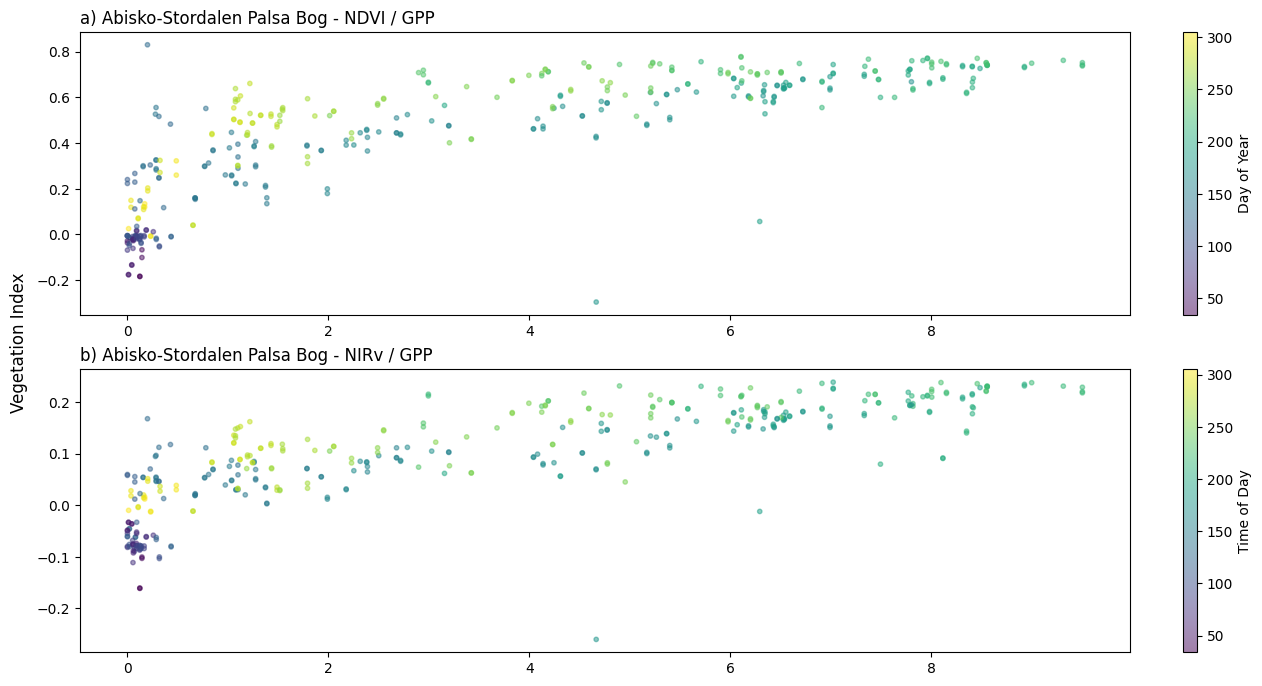

In [10]:
df = paired["Se_Sto"]

nrows = 2
ncols = 1
squish_factor = 1
fig, ax = plt.subplots(
    nrows = nrows, ncols=ncols,
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout=True
)
ax = ax.flatten()

sp0 = ax[0].scatter(
    x = df["Gross Primary Production (µmol)"], y = df["NDVI"],
    c = df["Time (Day of Year)"], s = 10, alpha = 0.5, edgecolors = None,
)
ax[0].set_title("a) Abisko-Stordalen Palsa Bog - NDVI / GPP", loc = "left")
fig.colorbar(sp0, ax = ax[0], label = "Day of Year")

sp1 = ax[1].scatter(
    x = df["Gross Primary Production (µmol)"], y = df["NIRv"],
    c = df["Time (Day of Year)"], s = 10, alpha = 0.5, edgecolors = None,
)
ax[1].set_title("b) Abisko-Stordalen Palsa Bog - NIRv / GPP", loc="left")
fig.colorbar(sp1, ax=ax[1], label="Time of Day")

fig.supylabel("Vegetation Index")

Train Random Forest Regressor

In [18]:
def randomforest_train_prep(
    dataframe,
    training_features,
    target_feature,
    categorical_features = None,
    test_proportion = 0.2,
    seed = 2
):
    
    # One-hot Encode Categorical Variables
    dataframe = pd.get_dummies(dataframe, columns = categorical_features, drop_first = False)
    
    # Define your target
    target = target_feature

    # Select relevant features
    X = dataframe[training_features]
    y = dataframe[target]
    
    # Check for missing values
    X = X.dropna()
    y = y.loc[X.index]  # Ensure same indices
    
    # Split into train and test subsets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_proportion, random_state = seed)
    
    return {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}

def randomforest_apply_prep(
    dataframe,
    training_features,
    target_feature,
    categorical_features = None,
    test_proportion = 0.2,
    seed = 2
):
    
    # One-hot Encode Categorical Variables
    dataframe = pd.get_dummies(dataframe, columns = categorical_features, drop_first = False)
    
    # Select relevant features
    X = dataframe[training_features]
    
    # Predict using the trained model
    predictions = model.predict(dataframe[training_features])
    
    return predictions

R^2 Score: 0.9603715632662673
RMSE: 0.3082362989259592


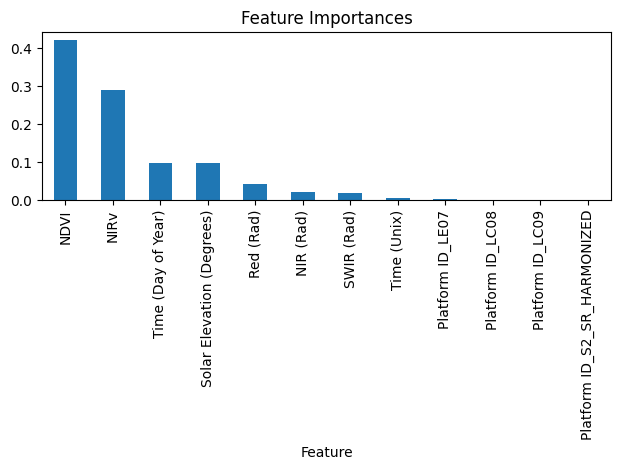

In [12]:
training_features = ["Red (Rad)", "NIR (Rad)", "SWIR (Rad)", "Solar Elevation (Degrees)", "Time (Day of Year)", "Time (Unix)", "Platform ID_LC08", "Platform ID_LC09", "Platform ID_LE07","Platform ID_S2_SR_HARMONIZED", "NDVI", "NIRv"]

randomforest_input = randomforest_train_prep(
    dataframe = paired["Se_Sto"],
    training_features = training_features,
    target_feature = "Gross Primary Production (µmol)",
    categorical_features = ["Platform ID"],
    test_proportion = 0.2
)

# Train Random Forest Regressor model
model = RandomForestRegressor(
    n_estimators = 1000,
    max_depth = None,
    min_samples_split = 2, min_samples_leaf=1,
    max_features = 0.8,
    bootstrap = True,
    random_state = 2)
model.fit(randomforest_input["X_train"], randomforest_input["y_train"])

# How good is the model?
y_pred = model.predict(randomforest_input["X_test"])
r2 = r2_score(randomforest_input["y_test"], y_pred)
rmse = mean_squared_error(randomforest_input["y_test"], y_pred)
print("R^2 Score:", r2)
print("RMSE:", rmse)

# What features were important?
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({"Feature": training_features, "Importance": importances})
feature_importance_df.sort_values(by = "Importance", ascending = False, inplace = True)

feature_importance_df.plot(kind = "bar", x = "Feature", y = "Importance", legend=False)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

paired["Se_Sto_Forest"] = {
    "Model": model,
    "r2": r2,
    "RMSE": rmse,
    "training_features": training_features,
    "feature_importance_df": feature_importance_df
}

Apply Model to Rest of Timeseries

In [19]:
satellite["Se_Sto"]["Predicted Gross Primary Production (µmol)"] = randomforest_apply_prep(
    dataframe = satellite["Se_Sto"],
    training_features = training_features,
    target_feature = "Gross Primary Production (µmol)",
    categorical_features = ["Platform ID"],
    test_proportion = 0.2
)

Preview Flux tower Informed Satellite GPP Estimate!

Text(0.0, 1.0, 'a) Abisko-Stordalen Palsa Bog - adjGPP / Time (Datetime)')

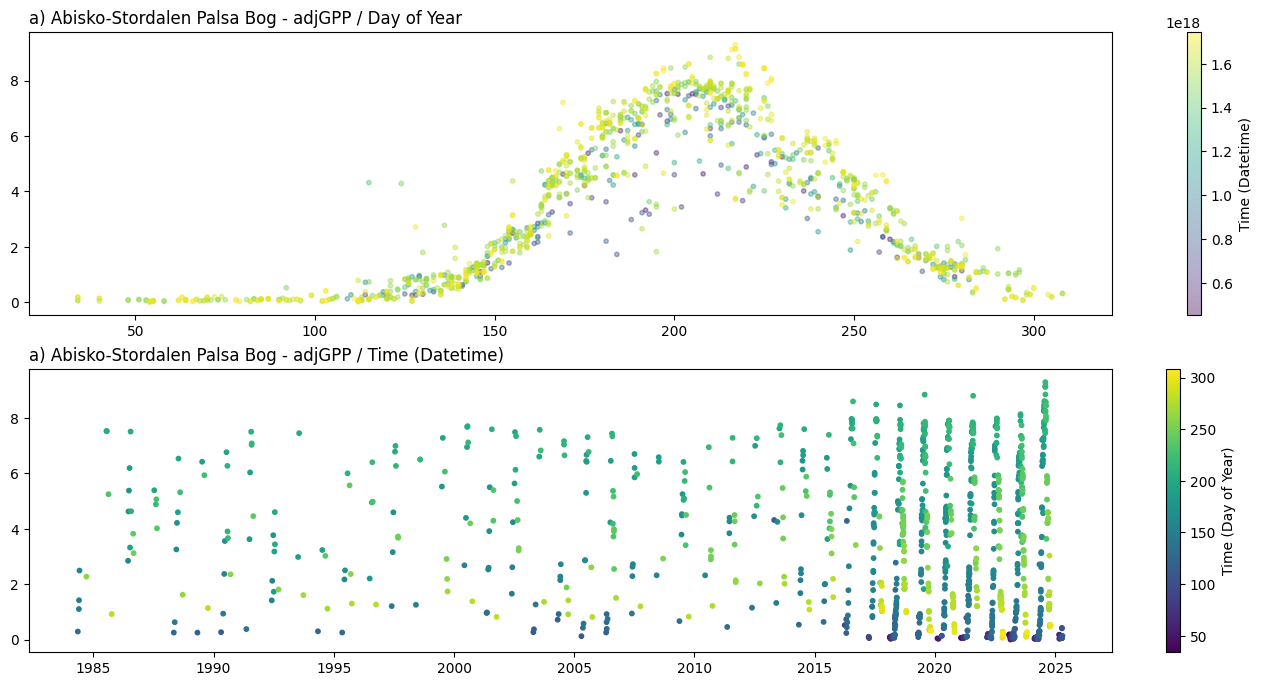

In [43]:
nrows = 2
ncols = 1
squish_factor = 1
fig, ax = plt.subplots(
    nrows = nrows, ncols = ncols, 
    figsize = (fig_wide, (fig_wide / fig_gold) * ((nrows - 1) / ncols) - squish_factor),
    sharex = False, constrained_layout = True
)
ax = ax.flatten()

sp0 = ax[0].scatter(
    x = df["Time (Day of Year)"], y = df["Predicted Gross Primary Production (µmol)"],
    c = df["Time (Datetime)"], s = 10, alpha = 0.4, edgecolors = None
)
ax[0].set_title("a) Abisko-Stordalen Palsa Bog - adjGPP / Day of Year", loc = "left")
fig.colorbar(sp0, ax = ax[0], label = "Time (Datetime)")

sp1 = ax[1].scatter(
    df["Time (Datetime)"].sort_values(), df["Predicted Gross Primary Production (µmol)"],
    c = df["Time (Day of Year)"], alpha = 1, s = 10
)
fig.colorbar(sp1, ax=ax[1], label="Time (Day of Year)")
ax[1].set_title("a) Abisko-Stordalen Palsa Bog - adjGPP / Time (Datetime)", loc = "left")